# Dataset from Kaggle
**Hurricanes and Typhoons, 1851-2014** by National Oceanic and Atmospheric Administration (NOAA)

Dataset includes two separate CSV files. We combine into one CSV file and apply some preprocessing.

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np

# data file paths in repo
DATA_DIR = Path("data")
ATLANTIC_PATH = DATA_DIR / "atlantic.csv"
PACIFIC_PATH  = DATA_DIR / "pacific.csv"
STORMS_PATH   = DATA_DIR / "storms.csv"

# load databases and combine
df_atl = pd.read_csv(ATLANTIC_PATH)
df_pac = pd.read_csv(PACIFIC_PATH)
df = pd.concat([df_atl, df_pac], ignore_index=True)

# drop columns with missing values
cols_to_drop = [
  "Event",
  "Minimum Pressure",
  "Low Wind NE", "Low Wind SE", "Low Wind SW", "Low Wind NW",
  "Moderate Wind NE", "Moderate Wind SE", "Moderate Wind SW", "Moderate Wind NW",
  "High Wind NE", "High Wind SE", "High Wind SW", "High Wind NW"
]
df = df.drop(columns=cols_to_drop)

# convert Lat/Long to floats
def parse_lat(val):
  if pd.isna(val):
    return np.nan
  s = str(val).strip()
  if s == "" or s == "-999":
    return np.nan
  direction = s[-1].upper()
  number = float(s[:-1])
  if direction == "S":
    number = -number
  return number

def parse_lon(val):
  if pd.isna(val):
    return np.nan
  s = str(val).strip()
  if s == "" or s == "-999":
    return np.nan
  direction = s[-1].upper()
  number = float(s[:-1])
  if direction == "W":
    number = -number
  return number

df["Latitude"] = df["Latitude"].apply(parse_lat)
df["Longitude"] = df["Longitude"].apply(parse_lon)
# normalize longitude
df["Longitude"] = ((df["Longitude"] + 180) % 360) - 180

# normalize storm status to int
status_map = {
  "DB": 0,
  "LO": 1,
  "SD": 2,
  "TD": 3,
  "WV": 3,
  "SS": 4,
  "TS": 5,
  "HU": 6,
  "ST": 6,
  "EX": 7,
  "ET": 7,
  "PT": 8
}
df["Status"] = df["Status"].astype(str).str.strip().map(status_map)

# save combined file
df.to_csv(STORMS_PATH, index=False)
print(f"Saved cleaned dataset to {STORMS_PATH}")

Saved cleaned dataset to data\storms.csv


# Further Preprocessing

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("data")
STORMS_PATH = DATA_DIR / "storms.csv"

df = pd.read_csv(STORMS_PATH)

# combine Date and Time to string and converting them to datetime values
df["Date"] = df["Date"].astype(str).str.zfill(8)   # YYYYMMDD
df["Time"] = df["Time"].astype(str).str.zfill(4)   # HHMM
df["Datetime"] = pd.to_datetime(df["Date"] + df["Time"],
                                format="%Y%m%d%H%M")

# sort rows by storm ID and datetime
df = df.sort_values(["ID", "Datetime"]).reset_index(drop=True)

# calculate hours since storm began for each row
genesis_time = df.groupby("ID")["Datetime"].transform("min")
df["hours_since_genesis"] = (df["Datetime"] - genesis_time).dt.total_seconds() / 3600.0

# use the last 4 rows (24 hours) to predict
input_steps = 4

# predict the next 4 rows (24 hours)
forecast_steps = 4

# columns used for prediction model
feature_cols = ["Latitude", "Longitude", "Maximum Wind", "Status", "hours_since_genesis"]

X_list = []
y_deltas_list = []
y_alive_list = []
seq_ids = []

for storm_id, g in df.groupby("ID"):
  g = g.sort_values("Datetime").reset_index(drop=True)

  # if storm lasted for less than 5 rows, skip it
  if len(g) < input_steps + 1:
    continue

  data = g[feature_cols].values
  # lats/lons used to build target deltas
  lats = g["Latitude"].values
  lons = g["Longitude"].values

  last_idx = len(g) - 1
  max_start = len(g) - input_steps - 1
  if max_start < 0:
    continue

  for start in range(max_start + 1):
    end_input_idx = start + input_steps - 1

    # 4x5 matrix input
    X_seq = data[start:start + input_steps]

    # last storm coordinates before prediction
    base_lat = lats[end_input_idx]
    base_lon = lons[end_input_idx]

    y_deltas = []
    y_alive = []

    # storm movement/status after "prediction point"
    for h in range(1, forecast_steps + 1):
      future_idx = end_input_idx + h

      if future_idx <= last_idx:

        lat_f = lats[future_idx]
        lon_f = lons[future_idx]

        # how far the storm moved in degrees
        dlat = lat_f - base_lat
        dlon = lon_f - base_lon

        y_deltas.append((dlat, dlon))
        y_alive.append(1.0)

      else:
        # if storm dissipated, placeholder delta which are masked in the loss
        y_deltas.append((0.0, 0.0))
        y_alive.append(0.0)

    X_list.append(X_seq)
    y_deltas_list.append(y_deltas)
    y_alive_list.append(y_alive)
    seq_ids.append(storm_id)

# convert lists to NumPy arrays
X = np.array(X_list, dtype=np.float32)
y_deltas = np.array(y_deltas_list, dtype=np.float32)
y_alive = np.array(y_alive_list, dtype=np.float32)
seq_ids = np.array(seq_ids)

print("X shape:", X.shape)
print("y_deltas shape:", y_deltas.shape)
print("y_alive shape:", y_alive.shape)

X shape: (63885, 4, 5)
y_deltas shape: (63885, 4, 2)
y_alive shape: (63885, 4)


# Splitting Data
80% training, 10% Testing, 10% Validation

In [3]:
# splitting by storms not rows
storm_ids = np.unique(seq_ids)

np.random.seed(42)
np.random.shuffle(storm_ids)

# 80-10-10 split for training-validation-testing
n = len(storm_ids)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

train_ids = storm_ids[:n_train]
val_ids   = storm_ids[n_train:n_train + n_val]
test_ids  = storm_ids[n_train + n_val:]

# masks for split
train_mask = np.isin(seq_ids, train_ids)
val_mask   = np.isin(seq_ids, val_ids)
test_mask  = np.isin(seq_ids, test_ids)

X_train      = X[train_mask]
y_deltas_train = y_deltas[train_mask]
y_alive_train  = y_alive[train_mask]

X_val        = X[val_mask]
y_deltas_val = y_deltas[val_mask]
y_alive_val  = y_alive[val_mask]

X_test        = X[test_mask]
y_deltas_test = y_deltas[test_mask]
y_alive_test  = y_alive[test_mask]

print("Total storms:", len(storm_ids))
print("Train storms:", np.unique(seq_ids[train_mask]).shape[0])
print("Val storms:  ", np.unique(seq_ids[val_mask]).shape[0])
print("Test storms: ", np.unique(seq_ids[test_mask]).shape[0])
print("X_train:", X_train.shape,
      "y_deltas_train:", y_deltas_train.shape,
      "y_alive_train:", y_alive_train.shape)
print("X_val:  ", X_val.shape,
      "y_deltas_val:", y_deltas_val.shape,
      "y_alive_val:", y_alive_val.shape)
print("X_test: ", X_test.shape,
      "y_deltas_test:", y_deltas_test.shape,
      "y_alive_test:", y_alive_test.shape)

Total storms: 2812
Train storms: 2249
Val storms:   281
Test storms:  282
X_train: (50834, 4, 5) y_deltas_train: (50834, 4, 2) y_alive_train: (50834, 4)
X_val:   (6967, 4, 5) y_deltas_val: (6967, 4, 2) y_alive_val: (6967, 4)
X_test:  (6084, 4, 5) y_deltas_test: (6084, 4, 2) y_alive_test: (6084, 4)


# Training GRU Model

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert NumPy arrays to PyTorch tensors
X_train_t      = torch.from_numpy(X_train).float()
y_deltas_train_t = torch.from_numpy(y_deltas_train).float()
y_alive_train_t  = torch.from_numpy(y_alive_train).float()

X_val_t        = torch.from_numpy(X_val).float()
y_deltas_val_t = torch.from_numpy(y_deltas_val).float()
y_alive_val_t  = torch.from_numpy(y_alive_val).float()

X_test_t        = torch.from_numpy(X_test).float()
y_deltas_test_t = torch.from_numpy(y_deltas_test).float()
y_alive_test_t  = torch.from_numpy(y_alive_test).float()

# mean and standard deviation of training input
feat_mean = X_train_t.mean(dim=(0, 1), keepdim=True)
feat_std  = X_train_t.std(dim=(0, 1), keepdim=True) + 1e-6

# standardize data using mean/std
X_train_t = (X_train_t - feat_mean) / feat_std
X_val_t   = (X_val_t   - feat_mean) / feat_std
X_test_t  = (X_test_t  - feat_mean) / feat_std

batch_size = 64

# wrap tensors into TensorDatasets
train_ds = TensorDataset(X_train_t, y_deltas_train_t, y_alive_train_t)
val_ds   = TensorDataset(X_val_t,   y_deltas_val_t,   y_alive_val_t)
test_ds  = TensorDataset(X_test_t,  y_deltas_test_t,  y_alive_test_t)

# DataLoader objects
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# Gated Recurrent Unit (GRU) model
class GRUTrackModel(nn.Module):
  def __init__(self, input_dim=5, hidden_dim=256, num_layers=2,
               forecast_steps=4):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.forecast_steps = forecast_steps

    self.gru = nn.GRU(
      input_size=input_dim,
      hidden_size=hidden_dim,
      num_layers=num_layers,
      batch_first=True
    )

    # maps the final GRU hidden state to outputs
    self.fc_coords = nn.Linear(hidden_dim, forecast_steps * 2)
    self.fc_alive = nn.Linear(hidden_dim, forecast_steps)

  def forward(self, x):
    out, h_n = self.gru(x)

    # GRU output at last step
    h_last = out[:, -1, :]

    # predict next coordinates and whether storm is alive
    coords_flat = self.fc_coords(h_last)
    coords_pred = coords_flat.view(-1, self.forecast_steps, 2)
    alive_logits = self.fc_alive(h_last)

    return coords_pred, alive_logits

# model dimensions
model = GRUTrackModel(
  input_dim=5,
  hidden_dim=256,
  num_layers=2,
  forecast_steps=4
).to(device)

# Smooth L1 Loss Function for coordinates
coord_loss_fn = nn.SmoothL1Loss(reduction="none")

# Binary Cross-Entropy (BCE) with Logits Loss Function for storm alive status
alive_loss_fn = nn.BCEWithLogitsLoss()

# AdamW optimizer with MultiStepLR scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[20],
    gamma=0.3
)

# weights for multi-task loss
lambda_coord = 1.0
lambda_alive = 0.5

# method to train one epoch
def train_one_epoch(model, loader, optimizer, device):
  model.train()
  total_loss = 0.0
  total_coord_loss = 0.0
  total_alive_loss = 0.0
  count = 0

  # loop through each batch
  for X_batch, y_coords_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_coords_batch = y_coords_batch.to(device)
    y_alive_batch = y_alive_batch.to(device)

    optimizer.zero_grad()

    # run model forward on current batch
    coords_pred, alive_logits = model(X_batch)

    # compute loss
    alive_loss = alive_loss_fn(alive_logits, y_alive_batch)
    coord_loss_per_elem = coord_loss_fn(coords_pred, y_coords_batch)
    # build mask for alive status
    alive_mask = (y_alive_batch > 0.5).unsqueeze(-1)
    alive_mask = alive_mask.expand_as(coord_loss_per_elem)
    masked_loss = coord_loss_per_elem * alive_mask.float()
    # number of valid(alive) elements
    denom = alive_mask.float().sum()
    if denom > 0:
      coord_loss = masked_loss.sum() / denom
    else:
      coord_loss = torch.tensor(0.0, device=device)

    # combine the two tasks into one scalar loss
    loss = lambda_coord * coord_loss + lambda_alive * alive_loss

    loss.backward()
    optimizer.step()

    # multiply each loss by batch_size to compute true average later
    batch_size = X_batch.size(0)
    total_loss += loss.item() * batch_size
    total_coord_loss += coord_loss.item() * batch_size
    total_alive_loss += alive_loss.item() * batch_size
    count += batch_size

  return (
    total_loss / count,
    total_coord_loss / count,
    total_alive_loss / count,
  )

# evaluation function
@torch.no_grad()
def evaluate(model, loader, device):
  model.eval()
  total_loss = 0.0
  total_coord_loss = 0.0
  total_alive_loss = 0.0
  count = 0

  # loop through each batch
  for X_batch, y_coords_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_coords_batch = y_coords_batch.to(device)
    y_alive_batch = y_alive_batch.to(device)

    # run model forward on current batch
    coords_pred, alive_logits = model(X_batch)

    # compute loss
    alive_loss = alive_loss_fn(alive_logits, y_alive_batch)
    coord_loss_per_elem = coord_loss_fn(coords_pred, y_coords_batch)
    alive_mask = (y_alive_batch > 0.5).unsqueeze(-1)
    alive_mask = alive_mask.expand_as(coord_loss_per_elem)
    masked_loss = coord_loss_per_elem * alive_mask.float()
    denom = alive_mask.float().sum()
    if denom > 0:
      coord_loss = masked_loss.sum() / denom
    else:
      coord_loss = torch.tensor(0.0, device=device)

    # combine the two tasks into one scalar loss
    loss = lambda_coord * coord_loss + lambda_alive * alive_loss

    # average losses for the whole dataset
    batch_size = X_batch.size(0)
    total_loss += loss.item() * batch_size
    total_coord_loss += coord_loss.item() * batch_size
    total_alive_loss += alive_loss.item() * batch_size
    count += batch_size

  return (
    total_loss / count,
    total_coord_loss / count,
    total_alive_loss / count,
  )

# for loss vs. epoch graph later
train_losses = []
val_losses = []

num_epochs = 50

# training loop
for epoch in range(1, num_epochs + 1):
  train_loss, train_coord_loss, train_alive_loss = train_one_epoch(
    model, train_loader, optimizer, device
  )
  val_loss, val_coord_loss, val_alive_loss = evaluate(
    model, val_loader, device
  )
  scheduler.step()

  print(
    f"Epoch {epoch:02d} | "
    f"Train Loss: {train_loss:.4f} (coord {train_coord_loss:.4f}, alive {train_alive_loss:.4f}) | "
    f"Val Loss: {val_loss:.4f} (coord {val_coord_loss:.4f}, alive {val_alive_loss:.4f})"
  )

  # for loss vs. epoch graph later
  train_losses.append(train_loss)
  val_losses.append(val_loss)

test_loss, test_coord_loss, test_alive_loss = evaluate(model, test_loader, device)
print(
  f"Test Loss: {test_loss:.4f} (coord {test_coord_loss:.4f}, alive {test_alive_loss:.4f})"
)

Epoch 01 | Train Loss: 0.9456 (coord 0.8477, alive 0.1959) | Val Loss: 0.9925 (coord 0.9096, alive 0.1658)
Epoch 02 | Train Loss: 0.7510 (coord 0.6618, alive 0.1784) | Val Loss: 0.8710 (coord 0.7909, alive 0.1602)
Epoch 03 | Train Loss: 0.6329 (coord 0.5462, alive 0.1735) | Val Loss: 0.7849 (coord 0.7054, alive 0.1590)
Epoch 04 | Train Loss: 0.5950 (coord 0.5107, alive 0.1685) | Val Loss: 0.7916 (coord 0.7131, alive 0.1569)
Epoch 05 | Train Loss: 0.5807 (coord 0.4978, alive 0.1660) | Val Loss: 0.7608 (coord 0.6848, alive 0.1520)
Epoch 06 | Train Loss: 0.5676 (coord 0.4858, alive 0.1636) | Val Loss: 0.7713 (coord 0.6955, alive 0.1516)
Epoch 07 | Train Loss: 0.5611 (coord 0.4801, alive 0.1620) | Val Loss: 0.7601 (coord 0.6856, alive 0.1491)
Epoch 08 | Train Loss: 0.5562 (coord 0.4758, alive 0.1607) | Val Loss: 0.7594 (coord 0.6844, alive 0.1501)
Epoch 09 | Train Loss: 0.5513 (coord 0.4714, alive 0.1598) | Val Loss: 0.7374 (coord 0.6636, alive 0.1475)
Epoch 10 | Train Loss: 0.5458 (coord 

# Testing Model Accuacy

In [10]:
import torch

# storm alive status accuracy
@torch.no_grad()
def alive_accuracy_per_horizon(model, loader, device, forecast_steps=4):
  model.eval()
  correct = torch.zeros(forecast_steps)
  total = torch.zeros(forecast_steps)

  for X_batch, y_coords_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_alive_batch = y_alive_batch.to(device)

    _, alive_logits = model(X_batch)
    alive_pred = (torch.sigmoid(alive_logits) > 0.5).float()

    for h in range(forecast_steps):
      correct[h] += (alive_pred[:, h] == y_alive_batch[:, h]).sum().item()
      total[h] += y_alive_batch[:, h].numel()

  acc_per_h = (correct / total).tolist()
  return acc_per_h

# haversine formula to calculate distance between two points on sphere
def haversine(lat1, lon1, lat2, lon2):
  lat1, lon1, lat2, lon2 = map(torch.deg2rad, [lat1, lon1, lat2, lon2])
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = torch.sin(dlat/2)**2 + torch.cos(lat1)*torch.cos(lat2)*torch.sin(dlon/2)**2
  c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
  return 6371.0 * c  # km

# coordinate accruacy (by error)
@torch.no_grad()
def coordinate_error_km_per_horizon_delta(model, loader, device,
                                          forecast_steps=4,
                                          only_when_alive=True):
  model.eval()
  total_dist = torch.zeros(forecast_steps)
  total_points = torch.zeros(forecast_steps)

  for X_batch, y_deltas_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_deltas_batch = y_deltas_batch.to(device)
    y_alive_batch  = y_alive_batch.to(device)

    deltas_pred, _ = model(X_batch)

    lat_last = X_batch[:, -1, 0] * feat_std[0, 0, 0] + feat_mean[0, 0, 0]
    lon_last = X_batch[:, -1, 1] * feat_std[0, 0, 1] + feat_mean[0, 0, 1]

    for h in range(forecast_steps):
      # predicted deltas
      dlat_pred = deltas_pred[:, h, 0]
      dlon_pred = deltas_pred[:, h, 1]

      # true deltas
      dlat_true = y_deltas_batch[:, h, 0]
      dlon_true = y_deltas_batch[:, h, 1]

      # convert deltas back to coordinates
      lat_pred = lat_last + dlat_pred
      lon_pred = lon_last + dlon_pred

      lat_true = lat_last + dlat_true
      lon_true = lon_last + dlon_true

      dist = haversine(lat_pred, lon_pred, lat_true, lon_true)

      if only_when_alive:
        mask = (y_alive_batch[:, h] > 0.5)
        if mask.sum() == 0:
          continue
        dist = dist[mask]

      total_dist[h]  += dist.sum().item()
      total_points[h] += dist.numel()

  mean_err = (total_dist / total_points).tolist()
  return mean_err

acc_test_h  = alive_accuracy_per_horizon(model, test_loader, device)
err_test_h = coordinate_error_km_per_horizon_delta(model, test_loader, device)
print("Alive Status Accuracy: ", acc_test_h)
print("Coordinate Error (km):", err_test_h)

Alive Status Accuracy:  [1.0, 0.9503616094589233, 0.906640350818634, 0.8703156113624573]
Coordinate Error (km): [37.58535385131836, 81.94349670410156, 133.1478271484375, 188.2516632080078]


# Baseline for Comparison
Persisetent baseline assumes future position of the storm will be the same as the current position. It assumes zero motion from the storm.

In [11]:
import torch

@torch.no_grad()
def persistence_error_km_per_horizon(loader, device, forecast_steps=4, only_when_alive=True):
  total_dist = torch.zeros(forecast_steps)
  total_points = torch.zeros(forecast_steps)

  for X_batch, y_coords_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_coords_batch = y_coords_batch.to(device)
    y_alive_batch = y_alive_batch.to(device)

    lat_last = X_batch[:, -1, 0] * feat_std[0, 0, 0] + feat_mean[0, 0, 0]
    lon_last = X_batch[:, -1, 1] * feat_std[0, 0, 1] + feat_mean[0, 0, 1]

    for h in range(forecast_steps):
      lat_true = y_coords_batch[:, h, 0]
      lon_true = y_coords_batch[:, h, 1]

      # baseline: predict same as last input
      lat_pred = lat_last
      lon_pred = lon_last

      dist = haversine(lat_pred, lon_pred, lat_true, lon_true)

      if only_when_alive:
        mask = (y_alive_batch[:, h] > 0.5)
        if mask.sum() == 0:
          continue
        dist = dist[mask]

      total_dist[h] += dist.sum().item()
      total_points[h] += dist.numel()

  return (total_dist / total_points).tolist()

persistence_test_err = persistence_error_km_per_horizon(
    test_loader,
    device=device,
    forecast_steps=4,
    only_when_alive=True
)

print("Persistence baseline (km): ", persistence_test_err)

Persistence baseline (km):  [9921.9287109375, 9864.8662109375, 9810.681640625, 9757.6376953125]


# Visualizing Resulting Model Accuracy
Visualizations include Predicted vs True Storm Coordinates on World Map, Alive Status Confusion Matrix, and Total Loss vs. Epoch Graph

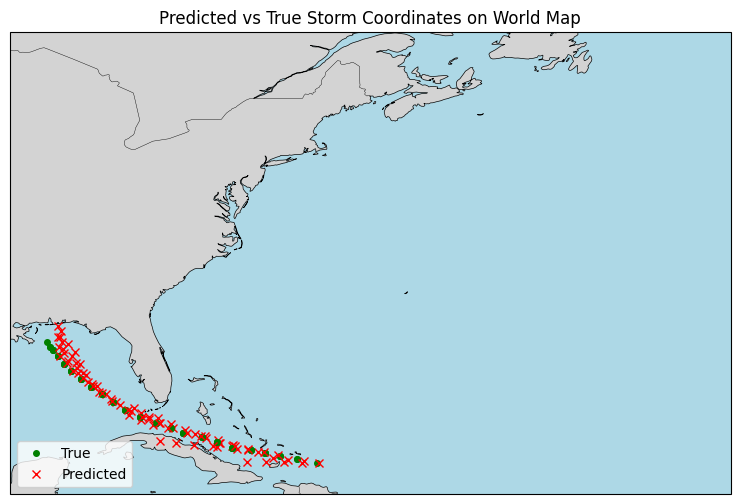

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch

@torch.no_grad()
def plot_pred_vs_true_map(model, loader, device, feat_mean, feat_std,
                          num_examples=20, forecast_steps=4):
  """
  Plot true vs predicted coordinates on a 2D Earth map using a dot plot.
  """

  model.eval()

  # Get one batch from the loader
  X_batch, y_deltas_batch, y_alive_batch = next(iter(loader))
  X_batch = X_batch.to(device)
  y_deltas_batch = y_deltas_batch.to(device)
  y_alive_batch = y_alive_batch.to(device)

  # Model predictions: our model returns (deltas_pred, alive_logits)
  deltas_pred, _ = model(X_batch)

  # Recover last known coordinates (undo standardization)
  # feature_cols = ["Latitude", "Longitude", "Maximum Wind", "Status", "hours_since_genesis"]
  lat_last = X_batch[:, -1, 0] * feat_std[0, 0, 0] + feat_mean[0, 0, 0]
  lon_last = X_batch[:, -1, 1] * feat_std[0, 0, 1] + feat_mean[0, 0, 1]

  # Convert deltas → absolute predicted coords
  lat_pred = lat_last.unsqueeze(1) + deltas_pred[:, :, 0]
  lon_pred = lon_last.unsqueeze(1) + deltas_pred[:, :, 1]

  # Convert true deltas → true coords
  lat_true = lat_last.unsqueeze(1) + y_deltas_batch[:, :, 0]
  lon_true = lon_last.unsqueeze(1) + y_deltas_batch[:, :, 1]

  # Set up map
  fig = plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())

  # Compute min/max lat/lon of all points
  all_lats = torch.cat([lat_true.reshape(-1), lat_pred.reshape(-1)]).cpu()
  all_lons = torch.cat([lon_true.reshape(-1), lon_pred.reshape(-1)]).cpu()

  lat_min, lat_max = float(all_lats.min()), float(all_lats.max())
  lon_min, lon_max = float(all_lons.min()), float(all_lons.max())

  # Add a margin so dots aren't on the border
  lat_margin = 2
  lon_margin = 2

  # Set map extent
  ax.set_extent(
      [lon_min - lon_margin, lon_max + lon_margin,
       lat_min - lat_margin, lat_max + lat_margin],
      crs=ccrs.PlateCarree()
  )

  # Base map features
  ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
  ax.add_feature(cfeature.BORDERS, linewidth=0.3)
  ax.add_feature(cfeature.LAND, facecolor='lightgray')
  ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

  # Only plot a limited number of storms for clarity
  n = min(num_examples, X_batch.size(0))

  for i in range(n):
    for h in range(forecast_steps):
      if y_alive_batch[i, h] < 0.5:
        continue  # skip dead storms

      # True point
      ax.plot(
        lon_true[i, h].cpu(), lat_true[i, h].cpu(),
        'go', markersize=4, transform=ccrs.PlateCarree(),
        label="True" if (i == 0 and h == 0) else ""
      )

      # Predicted point
      ax.plot(
        lon_pred[i, h].cpu(), lat_pred[i, h].cpu(),
        'rx', markersize=6, transform=ccrs.PlateCarree(),
        label="Predicted" if (i == 0 and h == 0) else ""
      )

  plt.title("Predicted vs True Storm Coordinates on World Map")
  plt.legend(loc='lower left')
  plt.show()

plot_pred_vs_true_map(model, test_loader, device, feat_mean, feat_std)

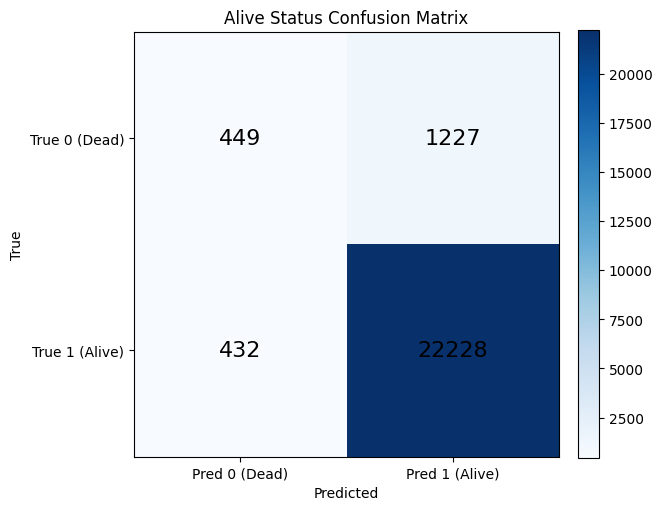

In [13]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def alive_confusion_matrix_overall(model, loader, device):
  # cm[true, pred], where rows = true, cols = pred
  cm = torch.zeros(2, 2, dtype=torch.int64)

  model.eval()

  for X_batch, y_deltas_batch, y_alive_batch in loader:
    X_batch = X_batch.to(device)
    y_alive_batch = y_alive_batch.to(device)

    # model outputs (deltas_pred, alive_logits)
    _, alive_logits = model(X_batch)
    preds = (torch.sigmoid(alive_logits) > 0.5).long()

    # flatten over batch and horizon
    true_flat = y_alive_batch.reshape(-1).long()
    pred_flat = preds.reshape(-1)

    TN = ((pred_flat == 0) & (true_flat == 0)).sum()
    FP = ((pred_flat == 1) & (true_flat == 0)).sum()
    FN = ((pred_flat == 0) & (true_flat == 1)).sum()
    TP = ((pred_flat == 1) & (true_flat == 1)).sum()

    cm += torch.tensor([[TN, FP],
                        [FN, TP]])

  return cm

cm = alive_confusion_matrix_overall(model, test_loader, device)
cm_np = cm.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_np, cmap="Blues")

for i in range(2):
  for j in range(2):
    ax.text(j, i, cm_np[i, j], ha="center", va="center", fontsize=16)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred 0 (Dead)", "Pred 1 (Alive)"])
ax.set_yticklabels(["True 0 (Dead)", "True 1 (Alive)"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Alive Status Confusion Matrix")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

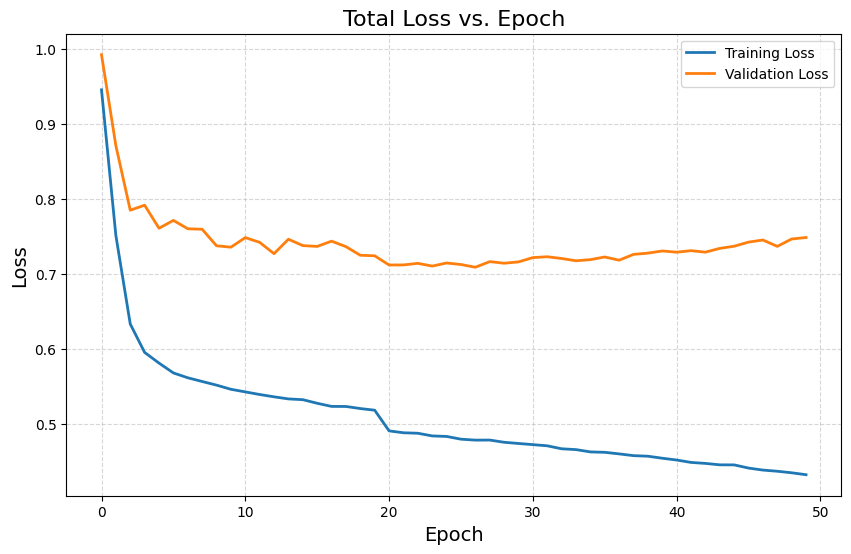

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)

plt.title("Total Loss vs. Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()